# `SimPEG(emg3d)`

Requires
- `simpeg>=0.22.2`
- `emg3d@inv-simpeg` (`pip install git+https://github.com/emsig/emg3d@inv-simpeg`

Very simple plus all possible inv-crimes (same mesh, some solver, ...).

For the "original" versions, see:
- https://curvenote.com/@prisae/emg3d-as-solver-for-simpeg/first-try [the very original]
- https://curvenote.com/@prisae/emg3d-as-solver-for-simpeg/simpeg-emg3d-inversion-automatic-grid [original with automatic gridding]

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import emg3d
import simpeg
import emg3d.inversion.simpeg as isimpeg

%run ../data/sampledata

In [2]:
%matplotlib widget

## Load Simulation (incl. Survey, Models, Data)

In [3]:
sim, model = load_data("../data/SimPEG-Original")
model_init = sim.model.copy()

# sim.tol_gradient = 1e-2  # could be reduced further to potentially speed-up more

Data loaded from «/home/dtr/Codes/devInv/data/SimPEG-Original.h5»
[emg3d v1.8.4.dev12+ge283125.d20240903 (format 1.0) on 2024-09-10T11:26:42.849097].


## Define active cells, instantiate FDEMSimulation and Inversion

In [4]:
# Create active cells
inds_active = np.zeros(sim.model.shape, dtype=bool)
inds_active[:, :, :-6] = True

# Instantiate SimPEG Simulation
FDEMSimulation = isimpeg.FDEMSimulation(simulation=sim, active_indices=inds_active)

# Define directives
starting_beta = simpeg.directives.BetaEstimate_ByEig(beta0_ratio=1)
beta_schedule = simpeg.directives.BetaSchedule(coolingFactor=2, coolingRate=1)
target_misfit = simpeg.directives.TargetMisfit(chifact=1)

# Instantiate Inversion
INV = isimpeg.Inversion(
    simulation=FDEMSimulation,
    maxIter=30,
    optimization_opts={
        'maxIterLS': 20,
        'maxIterCG': 20,
        'tolCG': 1e-3,
    },
    regularization_opts={
        'alpha_s': 1e-8,
        'alpha_x': 1,
        'alpha_y': 10,
        'alpha_z': 1,
    },
    directiveList=[
        starting_beta,
        beta_schedule,
        target_misfit,
    ],
)

## Run inversion

In [5]:
INV.run()

:: SimPEG(emg3d) START ::

Running inversion with SimPEG v0.22.2

                        simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the FDEMSimulation problem***
                        
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.21e+00  2.18e+05  0.00e+00  2.18e+05    4.49e+04      0              
   1  6.07e-01  1.08e+05  6.05e+03  1.12e+05    1.57e+04      0              
   2  3.03e-01  5.04e+04  2.68e+04  5.85e+04    1.64e+04      0              
   3  1.52e-01  2.21e+04  4.94e+04  2.96e+04    6.26e+03      0   Skip BFGS  
   4  7.58e-02  1.41e+04  5.88e+04  1.85e+04    3.17e+03      0   Skip BFGS  
   5  3.79e-02  9.85e+03  7.48e+04  1.27e+04    5.1

## Plots

Depth slice: -1700.0 m


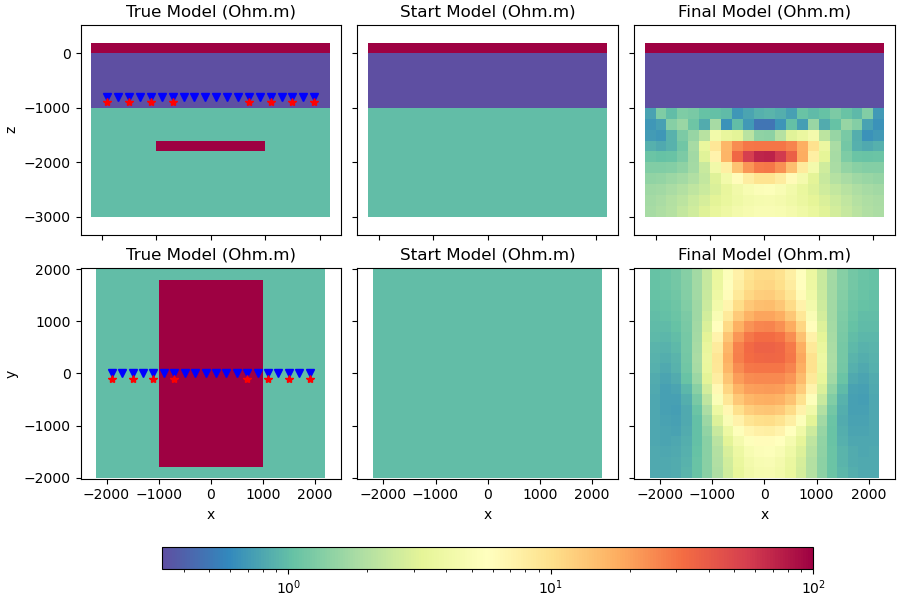

In [6]:
plot_models(sim, model_init, model, zind=6, vmin=0.33, vmax=100)

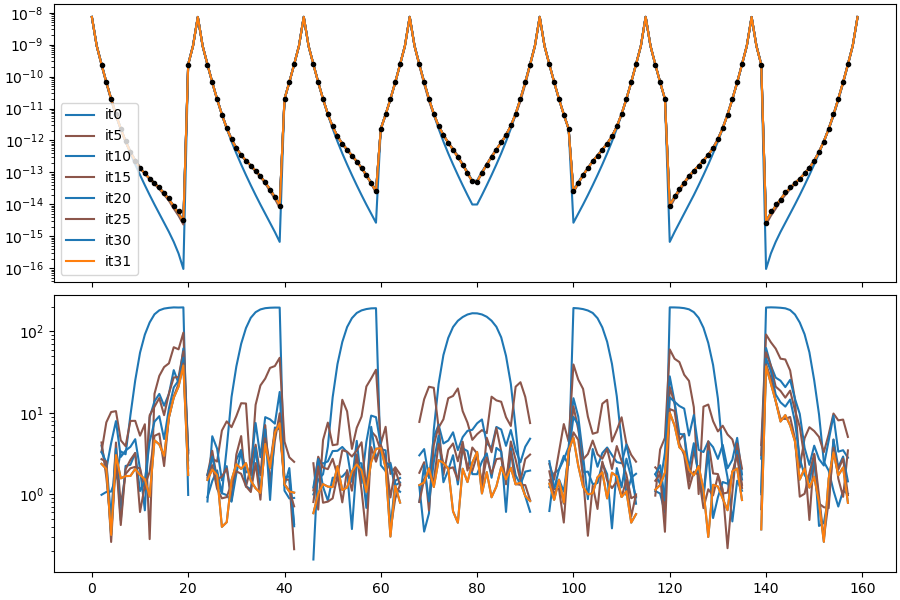

In [7]:
plot_responses(sim)

In [8]:
emg3d.Report()

--------------------------------------------------------------------------------
  Date: Thu Sep 12 10:54:52 2024 CEST

                OS : Linux (Ubuntu 22.04)
            CPU(s) : 16
           Machine : x86_64
      Architecture : 64bit
               RAM : 31.0 GiB
       Environment : Jupyter
       File system : ext4

  Python 3.12.5 | packaged by conda-forge | (main, Aug  8 2024, 18:36:51) [GCC
  12.4.0]

             numpy : 1.26.4
             scipy : 1.14.1
             numba : 0.60.0
             emg3d : 1.8.4.dev12+ge283125.d20240903
           empymod : 2.3.1
            xarray : 2024.7.0
        discretize : 0.10.0
              h5py : 3.11.0
        matplotlib : 3.9.2
              tqdm : 4.66.5
           IPython : 8.27.0
            simpeg : 0.22.2
            pydiso : 0.0.5
--------------------------------------------------------------------------------